# Imports and install

In [2]:
!pip install catboost
!pip install osmnx
!pip install geopy
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [3]:
import numpy as np
import pandas as pd

from sqlalchemy import create_engine
import json

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import Pool
from sklearn.metrics import f1_score, mean_absolute_error
from datetime import datetime

import osmnx as ox
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from catboost import CatBoostClassifier
import random
import os
from catboost import Pool
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

DEFAULT_RANDOM_SEED = 42

# Вспомогательные функции

In [ ]:
def get_region(row:str) -> str:
    if type(row) == str:
        arr = row.split(',')
        for elem_idx in range(len(arr)):
            if arr[elem_idx].strip() == 'Россия':
                res = arr[elem_idx-1].strip()
                if type(res) == str:
                    return res
                    break
                else:
                    return np.nan
    else:
        return row


def get_city(row:str) -> str:
    if type(row) == str:
        try:
            return row.split(',')[2].strip()
        except:
            return row.split(',')[0].strip()
    else:
        return row


def get_area_features(df:pd.DataFrame) -> pd.DataFrame:
    '''
    функция принимает на вход Pandas DataFrame с
    координатами точек, собирает по ним географические признаки
    и возвращает Pandas DataFrame

    df: Pandas DataFrame c коодинатами точек размещения банкоматов
    '''
    addresses = []
    cities, city_areas, city_district, federal_district  = [], [], [], []

    geolocator = Nominatim(user_agent='your_app_name')
    coordinates = np.array([list(df.loc[idx][['lat', 'long']].tolist()) for idx in range(len(df))])

    for coordinate in coordinates:
        addresses.append(geolocator.reverse(coordinate))

    for add in addresses:
        try:
            cities.append(add.raw['address']['city'])
        except:
            cities.append('')
        try:
            city_areas.append(add.raw['address']['county'])
        except:
            city_areas.append('')
        try:
            city_district.append(add.raw['address']['quarter'])
        except:
            city_district.append('')
        try:
            federal_district.append(add.raw['address']['state'])
        except:
            federal_district.append('')

    df['city'] = cities
    df['city_area'] = city_areas
    df['city_district'] = city_district
    df['federal_district'] = federal_district

    return df


def get_objects(tags:list, df:pd.DataFrame, flag:bool = False) -> pd.DataFrame:
    '''
    функция принимает на вход Pandas DataFrame с
    координатами точек и географическими признаками,
    а так же список из признаков для парсинга (дома, магазины и тп),
    собирает по ним признаки.
    Объекты парсятся в радиусе 100 метров от заданной точки.
    Так же flag переключает сбор даных
    для обучение (flag=True) и для инференса.
    Возвращает Pandas DataFrame

    tags: list из тэгов объектов, по которым будет проводится сбор данных
    df: Pandas DataFrame c коодинатами точек размещения банкоматов
    flag: флаг, переключающий сбор данных для обучения и инференса
    '''
    if flag:
        col_names = []

        for idx in range(len(tags)):
            col = list(tags[idx].values())[0]
            col_names.append(col)
            col_names.append('id')

        dfs = []
        df_tmp = pd.DataFrame(columns=col_names)

        for idx in range(len(df)):
            if idx % 100 == 0:
                print(f'Current sample number: {idx}.')
                print(f'Parsed {idx/6250*100}% of samples.')

            point = df.loc[idx][['lat', 'long']].tolist()
            df_tmp.loc[0, 'id'] = df.loc[idx]['id']
            for tag in tags:
                try:
                    geodf = ox.features_from_point(
                        center_point=point,
                        tags=tag,
                        dist=100
                        ).reset_index()
                    df_tmp.loc[0, list(tag.values())[0]] = len(geodf)
                except:
                    df_tmp.loc[0, list(tag.values())[0]] = 0

            df_tmp = df_tmp.loc[:,~df_tmp.columns.duplicated()]
            dfs.append(df_tmp)
            df_final = pd.concat(dfs)
            df_final = pd.merge(df, df_final, on=['id'])

        return df_final

    else:
        col_names = []

        for idx in range(len(tags)):
            col = list(tags[idx].values())[0]
            col_names.append(col)
            col_names.append('lat')
            col_names.append('long')

        df_final = pd.DataFrame(columns=col_names)

        for idx in range(len(df)):
            point = df.loc[idx][['lat', 'long']].tolist()
            df_final.loc[0, 'lat'] = point[0]
            df_final.loc[0, 'long'] = point[1]
            for tag in tags:
                try:
                    geodf = ox.features_from_point(
                        center_point=point,
                        tags=tag,
                        dist=100
                        ).reset_index()
                    df_final.loc[0, list(tag.values())[0]] = len(geodf)
                except:
                    df_final.loc[0, list(tag.values())[0]] = 0

            df_final = df_final.loc[:,~df_final.columns.duplicated()]
            df_final = pd.merge(df, df_final, on=['lat', 'long'])

        return df_final


def get_population(df:pd.DataFrame) -> pd.DataFrame:
    '''
    функция принимает на вход Pandas DataFrame с
    координатами точек, географическими и другими различными признаками
    (строения, школы, дома и тп) и подсчитывает ориентировочное население
    в радиусе 100 метров.
    Возвращает Pandas DataFrame

    df: Pandas DataFrame c собранными данными по объектам
    '''
    houses = ['semidetached_house', 'terrace', 'detached', 'house']
    apartments = ['apartments' , 'dormitory']

    all_populations = []

    for idx in range(len(df)):
        try:
            population_resp = ox.features_from_point(center_point=df.iloc[idx][['lat', 'long']].tolist(),
                       tags={'building' : [
                           'apartments' , 'dormitory','house', 'semidetached_house',
                           'detached', 'terrace',
                           ]}, dist=200).reset_index().fillna(1)

            population = (sum([int(x)*10*3 for x in population_resp[population_resp['building']
                                                                    .isin(apartments)]['building:levels'].tolist()])) + \
                         (sum([int(x)*3 for x in population_resp[population_resp['building']
                                                                 .isin(houses)]['building:levels'].tolist()]))

            all_populations.append(population)
        except:
            all_populations.append(0)

    df['population'] = all_populations

    return df


def fit_model(train_pool:Pool,
              validation_pool:Pool,
              learning_rate:float=0.003,
              iterations:int=30000,
              early_stopping_rounds:int=2000,
              task_type:str='CPU',
              **kwargs) -> CatBoostClassifier:
    '''
    Функция для тренировки модели.
    На вход подаются два Pool'а для обучения и валидации.
    Возвращает обученную модель. В процессе обучения логируются
    параметры.

    train_pool: Pool из библиотеки catboost с тренировочными данными
    validation_pool: Pool из библиотеки catboost с тренировочными данными
    learning_rate: int значение шага
    iterations: int количество итераций
    early_stopping_rounds: int количество итераций без улучшения скора модели
    task_type: str тип ядра процессора для обучения модели
    '''
    model = CatBoostClassifier(
        iterations=iterations,
        random_seed=DEFAULT_RANDOM_SEED,
        learning_rate=learning_rate,
        eval_metric='AUC',
        early_stopping_rounds=early_stopping_rounds,
        use_best_model= True,
        task_type=task_type,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )


def seedBasic(seed:int=42) -> None:
    '''
    Установка  random seed в окружение python
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


def get_f1_score() -> None:
    '''
    Функция отправляет пользвателю по запросу значение
    F1 score лучшей модели на текущий момент.
    '''
    fls = [x.split('/')[-1] for x in glob.glob('./outputs/*')]

    best_score = 0
    for mdl in fls:
        score = float(mdl.split('.c')[0].split('_')[-1])
        if score > best_score:
            best_score = score
            best_model = mdl
    return best_model


def get_all_futures_dataset() -> None:
    '''
    Функция подгружает вводные данные из .csv
    файла и собирает все необходимые признаки
    для каждой точки из датасета.
    '''
    df_train = pd.read_csv('./data/train_initial.csv')

    df_train = df_train.dropna(subset=['lat', 'long'])
    df_train = df_train.reset_index(drop=True)

    print('Area futures parsing start!')
    df = get_area_features(df_train)
    print('Area futures parsing DONE!!!')

    with open('./data/objects.json') as json_file:
        need_obj = json.load(json_file)

    print('Objects parsing start!')
    geo_data = get_objects(need_obj, df=df, flag=True)
    print('Objects parsing DONE!!!')

    print('Population parsing start!')
    geo_data = get_population(geo_data)
    print('Population parsing DONE!!!')

    geo_data.to_csv('./data/train_full.csv')


def train_model(
        learning_rate:float=0.003,
        iterations:int=30000,
        early_stopping_rounds:int=2000,
        task_type:str='CPU'
        ):

    '''
    Фуункция обучения модели.

    learning_rate: float значение шага
    iterations: int количество итераций
    early_stopping_rounds: int количество итераций без улучшения скора модели
    task_type: str тип ядра процессора для обучения модели
    '''

    seedBasic(DEFAULT_RANDOM_SEED)

    df = pd.read_csv('./data/train_full.csv', index_col='Unnamed: 0')

    df['target'] = minmax_scale(df['target'], feature_range=(1, 5), axis=0)
    df['target'] = df['target'].apply(np.round).apply(int)

    cat_features=[
    'atm_group', 'city', 'city_area',
    'city_district', 'federal_district',
    'administrative'
    ]

    df[cat_features] = df[cat_features].fillna('no_data')
    df['administrative'] = df['administrative'].apply(str)
    df['atm_group'] = df['atm_group'].apply(str)
    df = df.fillna(0)

    df.reset_index(drop=True, inplace=True)

    df_train_val = df.drop(
        ['id', 'address', 'address_rus','target'], axis=1
        )
    y_train_val = df['target']

    X_train, X_val, y_train, y_val = train_test_split(
        df_train_val, y_train_val,
        shuffle=True,
        stratify=y_train_val,
        train_size=0.85,
        random_state=DEFAULT_RANDOM_SEED
        )

    train_pool = Pool(
        X_train, y_train,
        cat_features=[
            'atm_group', 'city', 'city_area',
            'city_district', 'federal_district',
            'administrative'
            ]
            )

    validation_pool = Pool(
        X_val, y_val,
        cat_features=[
            'atm_group', 'city', 'city_area',
            'city_district', 'federal_district',
            'administrative'
            ]
            )

    print('Train dataset shape: {}\n'.format(train_pool.shape))

    model = fit_model(train_pool, validation_pool,
                      learning_rate, iterations,
                      early_stopping_rounds, task_type)

    err = f1_score(y_val, model.predict(X_val), average='micro')
    df_f1 = pd.DataFrame({'f1_score': [err]})
    df_f1.to_csv(f'./outputs/f1_score_{err}.csv', index=False)
    today_date = datetime.today().strftime('%d-%m-%Y')

    model_name = f'catboost_model_f1:{err}_date:{today_date}'

    model.save_model(
        f'./models/catboost_model_f1:{err}_date:{today_date}'
        )

    return err, model_name


def inference_model(lats:list, longs:list, atm:str) -> list:
    '''
    Функция инференса модели.

    lats: list список широт точек размещения коорднат
    longs: list список долготы точек размещения коорднат
    atm: str наименование банка-владельца банкомата
    '''

    seedBasic(DEFAULT_RANDOM_SEED)

    fls = [x.split('/')[-1] for x in glob.glob('./models/*')]

    best_score = 0
    for mdl in fls:
        score = float(mdl.split('.c')[0].split('_')[2].split(':')[-1])
        if score > best_score:
            best_score = score
            best_model = mdl

    model = CatBoostClassifier()
    model.load_model(f'./models/{best_model}')

    df = pd.DataFrame({'lat':lats, "long":longs, 'atm_group':atm})
    df = get_area_features(df)

    with open('./data/objects.json') as json_file:
        data = json.load(json_file)

    df = get_objects(data, df)
    df = get_population(df)

    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative'
        ]

    df.replace('', np.nan, inplace=True)
    df[cat_features] = df[cat_features].fillna('no_data')
    df['administrative'] = df['administrative'].apply(str)
    df['atm_group'] = df['atm_group'].apply(str)
    df = df.fillna(0)

    df.reset_index(drop=True, inplace=True)

    test_pool = Pool(
        df,
        cat_features=cat_features
        )

    predict = model.predict(test_pool)
    df['predict'] = predict

    return predict

# EDA

Загрузим базовый датасет и посмотрим что в нем есть

In [ ]:
train_initial = pd.read_csv('./data/train_initial.csv')

In [ ]:
print(f'Размер датасета: {train_initial.shape[0]} строк и {train_initial.shape[1]} колонок' )
train_initial

Размер датасета: 6258 строк и 7 колонок


,id,atm_group,address,address_rus,lat,long,target
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277
...,...,...,...,...,...,...,...
6253,4402.0,8083.0,"FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.045259,129.748896,0.207916
6254,4421.0,8083.0,"STROITELEY, 43 Novokuznetsk","проспект Строителей, 43, Новокузнецк, Кемеровс...",53.769459,87.117251,0.062220
6255,4422.0,8083.0,"Rublevskoye sh, 62 Moskva","Рублёвское шоссе, 62, Москва, Россия, 121609",55.766212,37.380875,0.108743
6256,4426.0,8083.0,"EFANOVA, 22 Zyryanskoye","улица Ефанова, 22, село Зырянское, Зырянский р...",56.838223,86.640829,0.148938


Проверим Датасет на пропуски

In [ ]:
train_initial.isna().sum()

id             0
atm_group      0
address        0
address_rus    0
lat            0
long           0
target         0
dtype: int64

Все отлично, в основных колонках atm_group, lat и long пропусков нет.

Посмотрим на распределение признака принадлежности банкомата определенному банку.


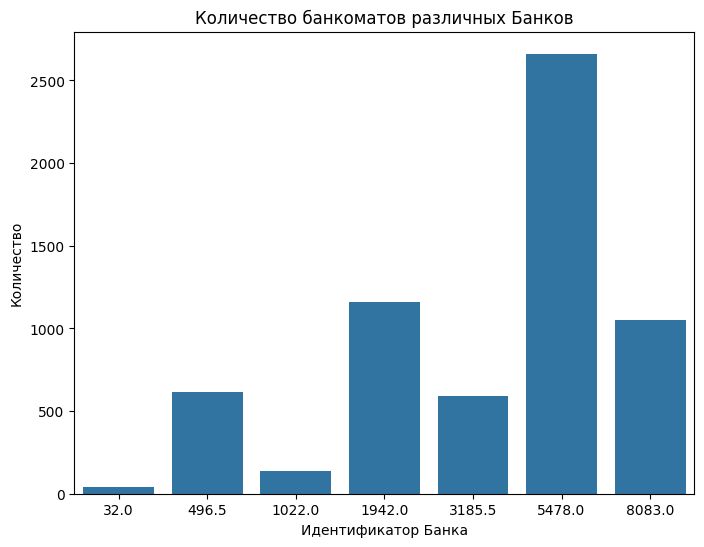

In [ ]:
value_counts = train_initial['atm_group'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Идентификатор Банка')
plt.ylabel('Количество')
plt.title('Количество банкоматов различных Банков')
plt.show()

Ну и отрисуем карту с расположением всех точек из нашего Датасета

In [ ]:
geo_figure = px.scatter_mapbox(
    train_initial,
    lat = "lat",
    lon = "long",
    center = {"lat": 58.38, "lon": 97.47},
    width = 1100,
    height = 600,
    hover_data = ["address_rus"],
)

geo_figure.update_layout(mapbox_style="open-street-map")

geo_figure.show()

Очевидно, что все точки находятся на территории РФ. Так же, карта интерактивная, ее можно двигать, скроллить и при наведении на конкретную точку выводится ее адрес

В целом, наверное, с первичным анализом данных все, оставим самое интересное для обогащения данных.

# Baseline

Построим простейшие модели на имеющихся данных.

In [ ]:
train_initial['target'] = minmax_scale(train_initial['target'], feature_range=(1, 5), axis=0)
train_initial['target'] = train_initial['target'].apply(np.round).apply(int)

train_initial['city'] = train_initial['address_rus'].apply(get_city)
train_initial['region'] = train_initial['address_rus'].apply(get_region)

train_initial = train_initial.dropna()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(train_initial).drop(['id', 'target'], axis=1),
    train_initial['target'],
    test_size=0.2,
    random_state=13)

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)
predicts = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test, predicts)

3586763.4293138925

Очевидно, что ошибка просто гигантская. Попробуем другой подход - будем решать задачу классификации

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(train_initial).drop(['id', 'target'], axis=1),
    train_initial['target'],
    test_size=0.2,
    random_state=13)

model = LogisticRegression()

model.fit(X_train, y_train)
predicts = model.predict(X_test)

In [ ]:
f1_score(y_test, predicts, average='macro')

0.2927957781562267

Аналогично предыдущей модели, результаты ужасные.

Зафиксируем их и пойдем в сторону обогащения данных.

- f1_score - 0.2927957781562267
- mean_absolute_error - 3586763.4293138925

# Обогащение данных

Займемся парсингом геоданных!

В качестве инструмента будем использовать ресурс  **OpenStreetMap** вернее его Python обертку **OSMx**

В кратце алгоритм парсинга данных:
- загружается исходный Датасет
- собираются фичи, связанные с геграфией (город, село, облать и тп)
- собираются фичи, связанные с объектами, предварительно сохраненные в objects.json файле (кафе, рестораны, здания и тп)
- рассчитывается население в радиусе 100м от заданной точки координат (фича "population")

**!!!ВНИМАНИЕ!!!**

Сбор данных занимает от 30 до 40 часов в зависимости от стабильности подключения.

In [ ]:
train_full = get_all_futures_dataset()
train_full.to_csv('./data/train_full.csv', index=False)

После такой длительной работы, сохраним данные.

P.S.

Пусть не смущает весь парсинг в одну строку, простыня кода для этих функций во втором разделе этого ноутбука

А вот список объектов, данные по которым собирались выше:

In [ ]:
with open('./data/objects.json') as json_file:
    data = json.load(json_file)

data

[{'amenity': 'fast_food'},
 {'amenity': 'cafe'},
 {'amenity': 'bar'},
 {'amenity': 'pub'},
 {'amenity': 'restaurant'},
 {'amenity': 'college'},
 {'amenity': 'kindergarten'},
 {'amenity': 'library'},
 {'amenity': 'training'},
 {'amenity': 'school'},
 {'amenity': 'traffic_park'},
 {'amenity': 'university'},
 {'amenity': 'bicycle_parking'},
 {'amenity': 'bus_station'},
 {'amenity': 'car_sharing'},
 {'amenity': 'fuel'},
 {'amenity': 'parking'},
 {'amenity': 'taxi'},
 {'amenity': 'atm'},
 {'amenity': 'payment_terminal'},
 {'amenity': 'bank'},
 {'amenity': 'bureau_de_change'},
 {'amenity': 'money_transfer'},
 {'amenity': 'payment_centre'},
 {'amenity': 'clinic'},
 {'amenity': 'hospital'},
 {'amenity': 'pharmacy'},
 {'amenity': 'social_facility'},
 {'amenity': 'cinema'},
 {'amenity': 'community_centre'},
 {'amenity': 'conference_centre'},
 {'amenity': 'events_venue'},
 {'amenity': 'exhibition_centre'},
 {'amenity': 'nightclub'},
 {'amenity': 'social_centre'},
 {'amenity': 'theatre'},
 {'ameni

In [ ]:
types, objects = [],[]

for i in data:
    types.append(list(i.items())[0][0])
    objects.append(list(i.items())[0][1])

In [ ]:
excel_df = pd.DataFrame({'Группа объектов':types, 'Тип объекта': objects})
excel_df['Описание'] = ''

In [ ]:
excel_df.to_excel('ex.xlsx', index=False)

In [ ]:
for i in data:
  print(list(i.items())[0][0])
  break

amenity


Подробнее про объекты и их тэгирование можно прочитать [в первоисточнике](https://wiki.openstreetmap.org/wiki/RU:Объекты_карты)

Ну и напоследок, посмотрим что у нас получилось:

In [18]:
import pandas as pd

In [24]:
df = pd.read_csv('./data/train_full.csv')

print(f'Размер датасета: {df.shape}')
df.head()

Размер датасета: (6258, 72)


,id,atm_group,address,address_rus,lat,long,target,city,city_area,city_district,...,supermarket,warehouse,religious,church,government,station,tram,platform,administrative,population
0,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,Южно-Сахалинск,городской округ Южно-Сахалинск,XIV микрорайон,...,2,0,0,0,0,0,0,1,0,4680
1,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,Южно-Сахалинск,городской округ Южно-Сахалинск,Центр,...,0,0,0,0,0,0,0,0,0,312
2,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,Москва,NaN,NaN,...,0,0,0,0,0,1,0,4,3,6990
3,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,Норильск,городской округ Норильск,NaN,...,0,0,0,0,0,0,0,4,2,3420
4,313.0,32.0,"RUSSKAYA, 16 VLADIVOSTOK","Русская улица, 16, Владивосток, Приморский кра...",43.165860,131.908212,-0.145001,Владивосток,Владивостокский городской округ,NaN,...,0,0,0,0,0,0,0,1,0,1260


In [6]:
df['target'] = minmax_scale(df['target'], feature_range=(1, 5), axis=0)
df['target'] = df['target'].apply(np.round).apply(int)

NameError: name 'minmax_scale' is not defined

In [7]:
df.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'city', 'city_area', 'city_district', 'federal_district', 'fast_food',
       'cafe', 'bar', 'pub', 'restaurant', 'college', 'kindergarten',
       'library', 'training', 'school', 'traffic_park', 'university',
       'bicycle_parking', 'bus_station', 'car_sharing', 'fuel', 'parking',
       'taxi', 'atm', 'payment_terminal', 'bank', 'bureau_de_change',
       'money_transfer', 'payment_centre', 'clinic', 'hospital', 'pharmacy',
       'social_facility', 'cinema', 'community_centre', 'conference_centre',
       'events_venue', 'exhibition_centre', 'nightclub', 'social_centre',
       'theatre', 'police', 'post_box', 'post_office', 'toilets',
       'internet_cafe', 'marketplace', 'apartments, detached', 'detached',
       'hotel', 'residential', 'commercial', 'industrial', 'kiosk', 'office',
       'retail', 'supermarket', 'warehouse', 'religious', 'church',
       'government', 'station', 'tram', 'plat

In [8]:
df.select_dtypes('number')

,id,atm_group,lat,long,target,fast_food,cafe,bar,pub,restaurant,...,supermarket,warehouse,religious,church,government,station,tram,platform,administrative,population
0,8532.0,32.0,46.937353,142.753348,0.029710,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,4680
1,8533.0,32.0,46.959413,142.741113,0.009540,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,312
2,8684.0,32.0,55.805827,37.515146,-0.094035,6,1,0,0,1,...,0,0,0,0,0,1,0,4,3,6990
3,37.0,32.0,69.343541,88.211228,0.079277,0,1,0,0,1,...,0,0,0,0,0,0,0,4,2,3420
4,313.0,32.0,43.165860,131.908212,-0.145001,0,2,0,0,1,...,0,0,0,0,0,0,0,1,0,1260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6253,4421.0,8083.0,53.769459,87.117251,0.062220,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6254,4422.0,8083.0,55.766212,37.380875,0.108743,3,1,0,0,0,...,0,0,0,0,0,0,0,1,3,54
6255,4426.0,8083.0,56.838223,86.640829,0.148938,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
6256,4429.0,8083.0,51.848725,109.905102,0.089919,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Моделирование Catboost

В этой части будем использовать уже модели "потяжелее".

В качестве таких, возьмем Catboost и простенькую нейронку с 3-мя полносвязными слоями и нелинейной активацией между слоями

P.S.

и да, state-of-art в решении задач машинного обучения на табличных данные есть ни что иное как бустинги, мы таки попробуем что то еще.


Посмотрим на распределение таргета

In [8]:
df['target'].value_counts()

target
2    2809
3    1845
4     661
1     552
5     391
Name: count, dtype: int64

Проверим, все ли у нас спарсилось. Проверим фичи

In [9]:
df.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'city', 'city_area', 'city_district', 'federal_district', 'fast_food',
       'cafe', 'bar', 'pub', 'restaurant', 'college', 'kindergarten',
       'library', 'training', 'school', 'traffic_park', 'university',
       'bicycle_parking', 'bus_station', 'car_sharing', 'fuel', 'parking',
       'taxi', 'atm', 'payment_terminal', 'bank', 'bureau_de_change',
       'money_transfer', 'payment_centre', 'clinic', 'hospital', 'pharmacy',
       'social_facility', 'cinema', 'community_centre', 'conference_centre',
       'events_venue', 'exhibition_centre', 'nightclub', 'social_centre',
       'theatre', 'police', 'post_box', 'post_office', 'toilets',
       'internet_cafe', 'marketplace', 'apartments, detached', 'detached',
       'hotel', 'residential', 'commercial', 'industrial', 'kiosk', 'office',
       'retail', 'supermarket', 'warehouse', 'religious', 'church',
       'government', 'station', 'tram', 'plat

Немного предобработки фичей. Убираем NaN'ы.

In [9]:
cat_features=[
    'atm_group', 'city', 'city_area',
    'city_district', 'federal_district',
    'administrative'
    ]

df[cat_features] = df[cat_features].fillna('no_data')
df['administrative'] = df['administrative'].apply(str)
df['atm_group'] = df['atm_group'].apply(str)
df = df.fillna(0)

Задаем функцию создания и обучения модели.

In [11]:
def fit_model(
    train_pool:Pool,
    validation_pool:Pool,
    lr=0.005,
    **kwargs
    ) -> CatBoostClassifier:

    model = CatBoostClassifier(
        iterations=30000,
        random_seed=DEFAULT_RANDOM_SEED,
        learning_rate=lr,
        eval_metric='AUC',
        early_stopping_rounds=1500,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

Отложим часть выборки для валидации модели.

Так же везде где можно фиксируем seed

In [12]:
df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['id', 'address', 'address_rus','target'], axis=1)
y_train_val = df['target']
X_train, X_val, y_train, y_val = train_test_split(
    df_train_val, y_train_val,
    shuffle=True,
    stratify=y_train_val,
    train_size=0.85,
    random_state=DEFAULT_RANDOM_SEED
    )

In [13]:
X_val.shape, y_val.shape

((939, 68), (939,))

Задаем Pool'ы для обучения и валидации

In [ ]:
train_pool = Pool(
    X_train, y_train,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative'
        ]
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative'
        ]
)

print('Train dataset size: {}\n'.format(train_pool.shape))

Train dataset size: (5319, 68)



Из функции обучения понятно, что в текущем применени модели ощутимо значимый гипермараметр - learning rate.

Опираясь на опыт и частые эмпирические значения, попробуем подобрать лучший для модели.

In [ ]:
lr_array = [
    0.0007, 0.001, 0.003, 0.005,
    0.009, 0.01, 0.05, 0.09,
    0.1, 0.3, 0.5
    ]
models = []
metrics = []

for lr in lr_array:
    print(f'Start model fit. Learning rate = {lr}')
    model = fit_model(train_pool, validation_pool, lr)
    metrics.append(f1_score(y_val, model.predict(X_val), average='micro'))
    models.append(f'catboost_lr:{lr}')

compare_df = pd.DataFrame({'model':models, 'score':metrics})

Start model fit. Learning rate = 0.0007
0:	test: 0.8009304	best: 0.8009304 (0)	total: 193ms	remaining: 1h 36m 43s
100:	test: 0.8369728	best: 0.8369728 (100)	total: 10.5s	remaining: 51m 52s
200:	test: 0.8408948	best: 0.8409032 (197)	total: 21.8s	remaining: 53m 50s
300:	test: 0.8428407	best: 0.8428663 (288)	total: 32.2s	remaining: 52m 53s
400:	test: 0.8442642	best: 0.8442642 (400)	total: 40.9s	remaining: 50m 16s
500:	test: 0.8464633	best: 0.8464633 (500)	total: 51.1s	remaining: 50m 7s
600:	test: 0.8487835	best: 0.8487835 (600)	total: 1m 1s	remaining: 50m 1s
700:	test: 0.8502571	best: 0.8504572 (689)	total: 1m 12s	remaining: 50m 21s
800:	test: 0.8513952	best: 0.8513952 (800)	total: 1m 21s	remaining: 49m 27s
900:	test: 0.8524875	best: 0.8524996 (899)	total: 1m 31s	remaining: 49m 27s
1000:	test: 0.8547598	best: 0.8547598 (1000)	total: 1m 42s	remaining: 49m 32s
1100:	test: 0.8561730	best: 0.8562139 (1097)	total: 1m 53s	remaining: 49m 36s
1200:	test: 0.8576167	best: 0.8576269 (1199)	total: 2m

In [ ]:
compare_df.sort_values('score', ascending=False)

,model,score
3,catboost_lr:0.005,0.629393
2,catboost_lr:0.003,0.626198
6,catboost_lr:0.05,0.626198
0,catboost_lr:0.0007,0.624068
4,catboost_lr:0.009,0.624068
5,catboost_lr:0.01,0.623003
1,catboost_lr:0.001,0.620873
8,catboost_lr:0.1,0.616613
7,catboost_lr:0.09,0.613419
9,catboost_lr:0.3,0.612354


Попробуем так же использовать большее количество фичей в качестве категориальных.

In [ ]:
train_pool = Pool(
    X_train, y_train,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative',
        'fast_food',
        'cafe', 'bar', 'pub', 'restaurant', 'college', 'kindergarten',
        'library', 'training', 'school', 'traffic_park', 'university',
        'bicycle_parking', 'bus_station', 'car_sharing', 'fuel', 'parking',
        'taxi', 'atm', 'payment_terminal', 'bank', 'bureau_de_change',
        'money_transfer', 'payment_centre', 'clinic', 'hospital', 'pharmacy',
        'social_facility', 'cinema', 'community_centre', 'conference_centre',
        'events_venue', 'exhibition_centre', 'nightclub', 'social_centre',
        'theatre', 'police', 'post_box', 'post_office', 'toilets',
        'internet_cafe', 'marketplace', 'apartments, detached', 'detached',
        'hotel', 'residential', 'commercial', 'industrial', 'kiosk', 'office',
        'retail', 'supermarket', 'warehouse', 'religious', 'church',
        'government', 'station', 'tram', 'platform'
        ]
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative',
        'fast_food',
        'cafe', 'bar', 'pub', 'restaurant', 'college', 'kindergarten',
        'library', 'training', 'school', 'traffic_park', 'university',
        'bicycle_parking', 'bus_station', 'car_sharing', 'fuel', 'parking',
        'taxi', 'atm', 'payment_terminal', 'bank', 'bureau_de_change',
        'money_transfer', 'payment_centre', 'clinic', 'hospital', 'pharmacy',
        'social_facility', 'cinema', 'community_centre', 'conference_centre',
        'events_venue', 'exhibition_centre', 'nightclub', 'social_centre',
        'theatre', 'police', 'post_box', 'post_office', 'toilets',
        'internet_cafe', 'marketplace', 'apartments, detached', 'detached',
        'hotel', 'residential', 'commercial', 'industrial', 'kiosk', 'office',
        'retail', 'supermarket', 'warehouse', 'religious', 'church',
        'government', 'station', 'tram', 'platform'
        ]
)

print('Train dataset size: {}\n'.format(train_pool.shape))

Train dataset size: (5319, 68)



In [ ]:
lr_array = [
    0.0007, 0.001, 0.003, 0.005,
    0.009, 0.01, 0.05, 0.09,
    0.1, 0.3, 0.5
    ]
models = []
metrics = []

for lr in lr_array:
    print(f'Start model fit. Learning rate = {lr}')
    model = fit_model(train_pool, validation_pool, lr)
    metrics.append(f1_score(y_val, model.predict(X_val), average='micro'))
    models.append(f'catboost_fullcategorical_lr:{lr}')

compare_df = pd.DataFrame({'model':models, 'score':metrics})

Start model fit. Learning rate = 0.0007


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 79.3ms	remaining: 39m 37s
100:	test: 0.8540541	best: 0.8542460 (97)	total: 2.87s	remaining: 14m 8s
200:	test: 0.8554987	best: 0.8555906 (198)	total: 4.03s	remaining: 9m 58s
300:	test: 0.8576801	best: 0.8577174 (299)	total: 5.19s	remaining: 8m 31s
400:	test: 0.8587557	best: 0.8588023 (396)	total: 6.32s	remaining: 7m 46s
500:	test: 0.8601903	best: 0.8602206 (497)	total: 7.51s	remaining: 7m 22s
600:	test: 0.8611177	best: 0.8611177 (600)	total: 8.64s	remaining: 7m 2s
700:	test: 0.8622044	best: 0.8622724 (698)	total: 9.81s	remaining: 6m 50s
800:	test: 0.8640043	best: 0.8640402 (793)	total: 11s	remaining: 6m 40s
900:	test: 0.8657388	best: 0.8657388 (900)	total: 12.6s	remaining: 6m 47s
1000:	test: 0.8671185	best: 0.8671282 (994)	total: 15.9s	remaining: 7m 40s
1100:	test: 0.8685571	best: 0.8685571 (1100)	total: 17.1s	remaining: 7m 27s
1200:	test: 0.8696672	best: 0.8696672 (1200)	total: 18.1s	remaining: 7m 15s
1300:	test: 0.8704526	best: 0.8704526 (

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 14ms	remaining: 6m 59s
100:	test: 0.8547044	best: 0.8547692 (96)	total: 1.17s	remaining: 5m 44s
200:	test: 0.8569650	best: 0.8570700 (199)	total: 2.25s	remaining: 5m 32s
300:	test: 0.8591140	best: 0.8591236 (299)	total: 5.48s	remaining: 9m
400:	test: 0.8604159	best: 0.8604253 (399)	total: 7.08s	remaining: 8m 43s
500:	test: 0.8625030	best: 0.8625030 (500)	total: 8.18s	remaining: 8m 1s
600:	test: 0.8644436	best: 0.8644888 (598)	total: 9.25s	remaining: 7m 32s
700:	test: 0.8668238	best: 0.8668295 (699)	total: 10.3s	remaining: 7m 10s
800:	test: 0.8685647	best: 0.8685993 (799)	total: 11.4s	remaining: 6m 54s
900:	test: 0.8704981	best: 0.8704981 (900)	total: 12.4s	remaining: 6m 41s
1000:	test: 0.8716462	best: 0.8716462 (1000)	total: 13.5s	remaining: 6m 32s
1100:	test: 0.8726165	best: 0.8726420 (1098)	total: 14.6s	remaining: 6m 24s
1200:	test: 0.8736502	best: 0.8736696 (1199)	total: 15.7s	remaining: 6m 16s
1300:	test: 0.8745002	best: 0.8745111 (1297

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 12.7ms	remaining: 6m 22s
100:	test: 0.8588179	best: 0.8589217 (97)	total: 3.95s	remaining: 19m 29s
200:	test: 0.8643191	best: 0.8643191 (200)	total: 5.2s	remaining: 12m 50s
300:	test: 0.8697336	best: 0.8697336 (300)	total: 6.34s	remaining: 10m 25s
400:	test: 0.8731675	best: 0.8731675 (400)	total: 7.42s	remaining: 9m 7s
500:	test: 0.8755349	best: 0.8755349 (500)	total: 8.51s	remaining: 8m 21s
600:	test: 0.8773933	best: 0.8773933 (600)	total: 9.6s	remaining: 7m 49s
700:	test: 0.8787719	best: 0.8788217 (699)	total: 10.7s	remaining: 7m 25s
800:	test: 0.8804810	best: 0.8805105 (798)	total: 11.8s	remaining: 7m 9s
900:	test: 0.8821176	best: 0.8821176 (900)	total: 12.9s	remaining: 6m 56s
1000:	test: 0.8832694	best: 0.8832913 (996)	total: 15.2s	remaining: 7m 19s
1100:	test: 0.8838589	best: 0.8839295 (1067)	total: 17.4s	remaining: 7m 35s
1200:	test: 0.8845624	best: 0.8845853 (1189)	total: 18.4s	remaining: 7m 21s
1300:	test: 0.8850168	best: 0.8850308 

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 13.8ms	remaining: 6m 52s
100:	test: 0.8626819	best: 0.8626819 (100)	total: 1.12s	remaining: 5m 31s
200:	test: 0.8718646	best: 0.8718646 (200)	total: 2.25s	remaining: 5m 34s
300:	test: 0.8762398	best: 0.8762666 (299)	total: 3.36s	remaining: 5m 31s
400:	test: 0.8786061	best: 0.8786494 (399)	total: 4.49s	remaining: 5m 31s
500:	test: 0.8808767	best: 0.8809594 (499)	total: 5.68s	remaining: 5m 34s
600:	test: 0.8834704	best: 0.8834704 (600)	total: 6.82s	remaining: 5m 33s
700:	test: 0.8850405	best: 0.8850739 (699)	total: 7.94s	remaining: 5m 31s
800:	test: 0.8858635	best: 0.8858704 (799)	total: 10.3s	remaining: 6m 14s
900:	test: 0.8862557	best: 0.8863897 (879)	total: 12.9s	remaining: 6m 56s
1000:	test: 0.8863712	best: 0.8863897 (879)	total: 14.1s	remaining: 6m 48s
1100:	test: 0.8864840	best: 0.8865078 (1043)	total: 15.2s	remaining: 6m 40s
1200:	test: 0.8868248	best: 0.8869197 (1164)	total: 16.4s	remaining: 6m 32s
1300:	test: 0.8869808	best: 0.887120

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 13.7ms	remaining: 6m 52s
100:	test: 0.8709243	best: 0.8709243 (100)	total: 1.16s	remaining: 5m 43s
200:	test: 0.8768730	best: 0.8769109 (195)	total: 2.4s	remaining: 5m 55s
300:	test: 0.8804166	best: 0.8804166 (300)	total: 3.59s	remaining: 5m 54s
400:	test: 0.8828083	best: 0.8828790 (395)	total: 4.74s	remaining: 5m 49s
500:	test: 0.8839553	best: 0.8839553 (500)	total: 5.87s	remaining: 5m 45s
600:	test: 0.8847376	best: 0.8847376 (600)	total: 8.31s	remaining: 6m 46s
700:	test: 0.8849559	best: 0.8850793 (692)	total: 10.8s	remaining: 7m 29s
800:	test: 0.8850815	best: 0.8850835 (794)	total: 11.8s	remaining: 7m 11s
900:	test: 0.8852088	best: 0.8853759 (863)	total: 12.9s	remaining: 6m 56s
1000:	test: 0.8850032	best: 0.8853759 (863)	total: 14s	remaining: 6m 44s
1100:	test: 0.8847217	best: 0.8853759 (863)	total: 15s	remaining: 6m 34s
1200:	test: 0.8848482	best: 0.8853759 (863)	total: 16.1s	remaining: 6m 26s
1300:	test: 0.8847457	best: 0.8853759 (863)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 13.6ms	remaining: 6m 48s
100:	test: 0.8720080	best: 0.8720080 (100)	total: 1.88s	remaining: 9m 16s
200:	test: 0.8781211	best: 0.8781637 (199)	total: 5.04s	remaining: 12m 27s
300:	test: 0.8832559	best: 0.8832559 (300)	total: 6.15s	remaining: 10m 6s
400:	test: 0.8848303	best: 0.8848579 (397)	total: 7.18s	remaining: 8m 49s
500:	test: 0.8855951	best: 0.8855965 (499)	total: 8.18s	remaining: 8m 1s
600:	test: 0.8859771	best: 0.8859771 (600)	total: 9.2s	remaining: 7m 29s
700:	test: 0.8859514	best: 0.8861259 (624)	total: 10.2s	remaining: 7m 6s
800:	test: 0.8858651	best: 0.8861259 (624)	total: 11.2s	remaining: 6m 48s
900:	test: 0.8857442	best: 0.8861259 (624)	total: 12.2s	remaining: 6m 34s
1000:	test: 0.8855970	best: 0.8861259 (624)	total: 13.3s	remaining: 6m 24s
1100:	test: 0.8853303	best: 0.8861259 (624)	total: 14.4s	remaining: 6m 17s
1200:	test: 0.8854739	best: 0.8861259 (624)	total: 17.9s	remaining: 7m 8s
1300:	test: 0.8854709	best: 0.8861259 (62

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 51.9ms	remaining: 25m 56s
100:	test: 0.8858740	best: 0.8858740 (100)	total: 1.52s	remaining: 7m 29s
200:	test: 0.8861846	best: 0.8867254 (164)	total: 2.74s	remaining: 6m 46s
300:	test: 0.8860130	best: 0.8867254 (164)	total: 3.92s	remaining: 6m 26s
400:	test: 0.8843888	best: 0.8867254 (164)	total: 5.04s	remaining: 6m 11s
500:	test: 0.8849584	best: 0.8867254 (164)	total: 6.18s	remaining: 6m 3s
600:	test: 0.8843209	best: 0.8867254 (164)	total: 7.29s	remaining: 5m 56s
700:	test: 0.8842945	best: 0.8867254 (164)	total: 8.42s	remaining: 5m 52s
800:	test: 0.8841634	best: 0.8867254 (164)	total: 9.55s	remaining: 5m 48s
900:	test: 0.8834876	best: 0.8867254 (164)	total: 12.4s	remaining: 6m 40s
1000:	test: 0.8828602	best: 0.8867254 (164)	total: 14.5s	remaining: 7m
1100:	test: 0.8827184	best: 0.8867254 (164)	total: 15.6s	remaining: 6m 48s
1200:	test: 0.8825770	best: 0.8867254 (164)	total: 16.6s	remaining: 6m 38s
1300:	test: 0.8830872	best: 0.8867254 (164

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 17.8ms	remaining: 8m 53s
100:	test: 0.8843735	best: 0.8843735 (100)	total: 1.16s	remaining: 5m 43s
200:	test: 0.8837922	best: 0.8848228 (119)	total: 4.79s	remaining: 11m 50s
300:	test: 0.8820508	best: 0.8848228 (119)	total: 5.98s	remaining: 9m 50s
400:	test: 0.8818754	best: 0.8848228 (119)	total: 7.08s	remaining: 8m 42s
500:	test: 0.8809499	best: 0.8848228 (119)	total: 8.21s	remaining: 8m 3s
600:	test: 0.8817348	best: 0.8848228 (119)	total: 9.37s	remaining: 7m 38s
700:	test: 0.8813219	best: 0.8848228 (119)	total: 10.5s	remaining: 7m 19s
800:	test: 0.8816292	best: 0.8848228 (119)	total: 11.6s	remaining: 7m 3s
900:	test: 0.8817714	best: 0.8848228 (119)	total: 14.1s	remaining: 7m 34s
1000:	test: 0.8829995	best: 0.8848228 (119)	total: 18.8s	remaining: 9m 3s
1100:	test: 0.8829164	best: 0.8848228 (119)	total: 19.9s	remaining: 8m 41s
1200:	test: 0.8832395	best: 0.8848228 (119)	total: 20.9s	remaining: 8m 20s
1300:	test: 0.8835061	best: 0.8848228 (1

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 12.9ms	remaining: 6m 27s
100:	test: 0.8821926	best: 0.8825666 (96)	total: 1.1s	remaining: 5m 26s
200:	test: 0.8825256	best: 0.8827193 (145)	total: 2.13s	remaining: 5m 16s
300:	test: 0.8815645	best: 0.8827419 (205)	total: 5.83s	remaining: 9m 35s
400:	test: 0.8815078	best: 0.8827419 (205)	total: 7s	remaining: 8m 36s
500:	test: 0.8819424	best: 0.8827419 (205)	total: 8.02s	remaining: 7m 52s
600:	test: 0.8810518	best: 0.8827419 (205)	total: 9.03s	remaining: 7m 21s
700:	test: 0.8806237	best: 0.8827419 (205)	total: 10s	remaining: 6m 59s
800:	test: 0.8820902	best: 0.8827419 (205)	total: 11s	remaining: 6m 41s
900:	test: 0.8823554	best: 0.8827419 (205)	total: 12s	remaining: 6m 29s
1000:	test: 0.8831849	best: 0.8831849 (1000)	total: 13s	remaining: 6m 17s
1100:	test: 0.8833445	best: 0.8834334 (1096)	total: 14s	remaining: 6m 8s
1200:	test: 0.8831552	best: 0.8834334 (1096)	total: 15s	remaining: 6m
1300:	test: 0.8831536	best: 0.8836155 (1236)	total: 17.8s

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 13ms	remaining: 6m 30s
100:	test: 0.8802571	best: 0.8834515 (16)	total: 1.09s	remaining: 5m 22s
200:	test: 0.8765133	best: 0.8834515 (16)	total: 2.15s	remaining: 5m 18s
300:	test: 0.8754052	best: 0.8834515 (16)	total: 3.24s	remaining: 5m 19s
400:	test: 0.8735217	best: 0.8834515 (16)	total: 5.89s	remaining: 7m 14s
500:	test: 0.8734908	best: 0.8834515 (16)	total: 8.16s	remaining: 8m
600:	test: 0.8728581	best: 0.8834515 (16)	total: 9.22s	remaining: 7m 31s
700:	test: 0.8716710	best: 0.8834515 (16)	total: 10.3s	remaining: 7m 9s
800:	test: 0.8707187	best: 0.8834515 (16)	total: 11.3s	remaining: 6m 51s
900:	test: 0.8699461	best: 0.8834515 (16)	total: 12.3s	remaining: 6m 37s
1000:	test: 0.8704439	best: 0.8834515 (16)	total: 13.3s	remaining: 6m 25s
1100:	test: 0.8699496	best: 0.8834515 (16)	total: 14.4s	remaining: 6m 17s
1200:	test: 0.8703013	best: 0.8834515 (16)	total: 15.4s	remaining: 6m 10s
1300:	test: 0.8707046	best: 0.8834515 (16)	total: 16.5s	r

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8359977	best: 0.8359977 (0)	total: 14ms	remaining: 7m
100:	test: 0.8814843	best: 0.8847974 (14)	total: 1.09s	remaining: 5m 22s
200:	test: 0.8812101	best: 0.8847974 (14)	total: 2.13s	remaining: 5m 16s
300:	test: 0.8801866	best: 0.8847974 (14)	total: 3.2s	remaining: 5m 15s
400:	test: 0.8794268	best: 0.8847974 (14)	total: 4.25s	remaining: 5m 14s
500:	test: 0.8802402	best: 0.8847974 (14)	total: 5.35s	remaining: 5m 15s
600:	test: 0.8806697	best: 0.8847974 (14)	total: 6.44s	remaining: 5m 15s
700:	test: 0.8800508	best: 0.8847974 (14)	total: 7.51s	remaining: 5m 13s
800:	test: 0.8780073	best: 0.8847974 (14)	total: 10.6s	remaining: 6m 25s
900:	test: 0.8772530	best: 0.8847974 (14)	total: 12.4s	remaining: 6m 40s
1000:	test: 0.8776149	best: 0.8847974 (14)	total: 13.4s	remaining: 6m 29s
1100:	test: 0.8776489	best: 0.8847974 (14)	total: 14.5s	remaining: 6m 19s
1200:	test: 0.8784006	best: 0.8847974 (14)	total: 15.5s	remaining: 6m 11s
1300:	test: 0.8779856	best: 0.8847974 (14)	total: 16.5s	r

In [ ]:
compare_df.sort_values('score', ascending=False)

,model,score
6,catboost_fullcategorical_lr:0.05,0.621938
0,catboost_fullcategorical_lr:0.0007,0.617678
3,catboost_fullcategorical_lr:0.005,0.617678
2,catboost_fullcategorical_lr:0.003,0.616613
1,catboost_fullcategorical_lr:0.001,0.614483
5,catboost_fullcategorical_lr:0.01,0.614483
7,catboost_fullcategorical_lr:0.09,0.614483
4,catboost_fullcategorical_lr:0.009,0.611289
9,catboost_fullcategorical_lr:0.3,0.605964
8,catboost_fullcategorical_lr:0.1,0.603834


В целом очевидно, что модели с числовыми признаками выигрывают.
Для лучше такой модели построим графики важности признаков и confuion matrix

In [ ]:
train_pool = Pool(
    X_train, y_train,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative'
        ]
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=[
        'atm_group', 'city', 'city_area',
        'city_district', 'federal_district',
        'administrative'
        ]
)

print('Train dataset size: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool, 0.005)
f1_score(y_val, model.predict(X_val), average='micro')

Train dataset size: (5319, 68)

0:	test: 0.8375501	best: 0.8375501 (0)	total: 16.8ms	remaining: 8m 22s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


100:	test: 0.8609833	best: 0.8610213 (97)	total: 1.47s	remaining: 7m 14s
200:	test: 0.8717652	best: 0.8717652 (200)	total: 2.6s	remaining: 6m 25s
300:	test: 0.8765356	best: 0.8765356 (300)	total: 3.67s	remaining: 6m 2s
400:	test: 0.8786528	best: 0.8787313 (387)	total: 7.54s	remaining: 9m 16s
500:	test: 0.8805673	best: 0.8805673 (500)	total: 8.75s	remaining: 8m 35s
600:	test: 0.8832903	best: 0.8832903 (600)	total: 9.87s	remaining: 8m 2s
700:	test: 0.8844550	best: 0.8845504 (695)	total: 11s	remaining: 7m 37s
800:	test: 0.8849183	best: 0.8849774 (788)	total: 12s	remaining: 7m 17s
900:	test: 0.8855136	best: 0.8855136 (900)	total: 13.1s	remaining: 7m 2s
1000:	test: 0.8856689	best: 0.8856689 (1000)	total: 14.1s	remaining: 6m 49s
1100:	test: 0.8858494	best: 0.8859129 (1087)	total: 16.1s	remaining: 7m 3s
1200:	test: 0.8861002	best: 0.8863370 (1169)	total: 19.2s	remaining: 7m 40s
1300:	test: 0.8863206	best: 0.8864282 (1298)	total: 24.8s	remaining: 9m 7s
1400:	test: 0.8863784	best: 0.8864282 (12

0.625133120340788

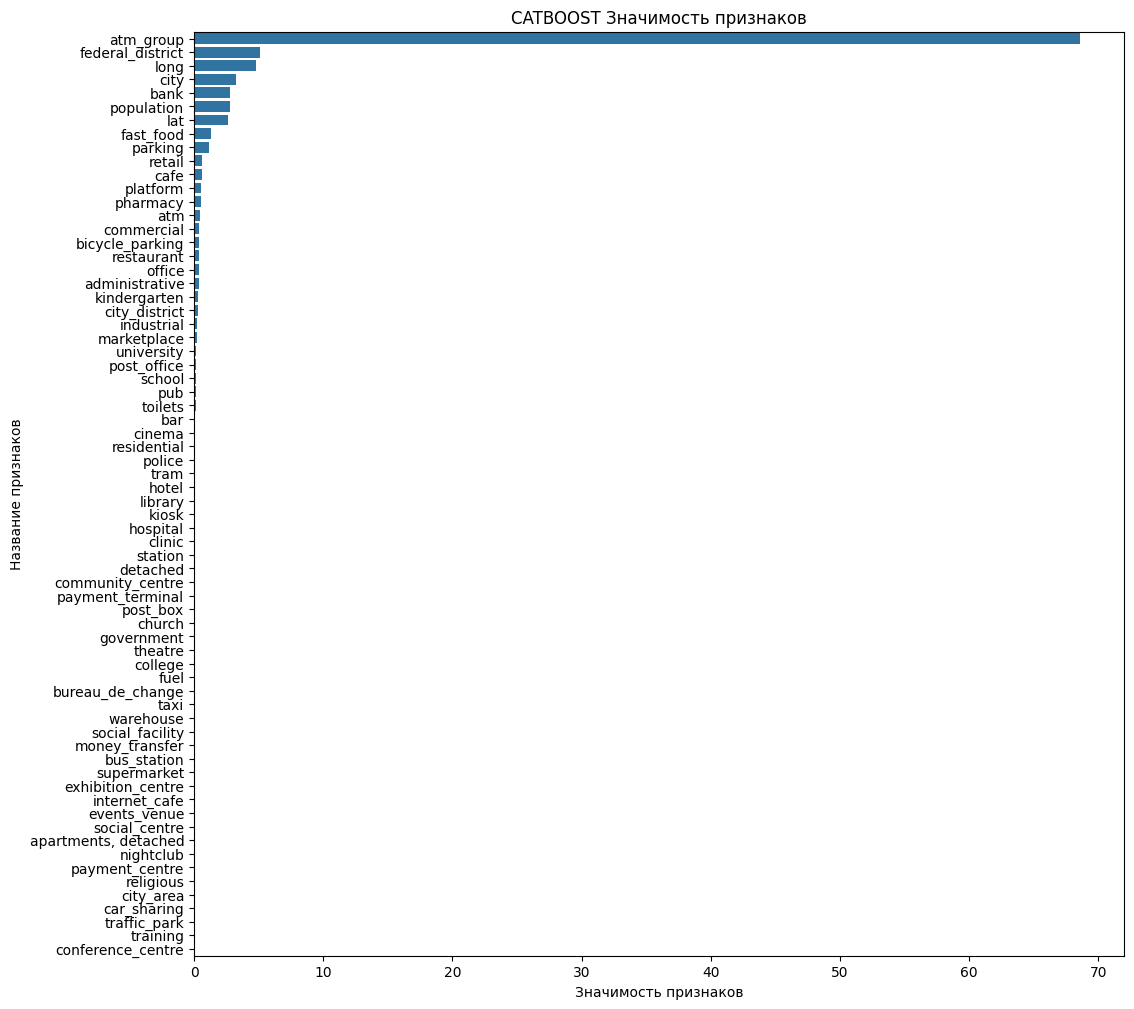

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'f_names':feature_names,'f_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['f_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(12,12))
    sns.barplot(x=fi_df['f_importance'], y=fi_df['f_names'])
    plt.title(model_type + 'Значимость признаков')
    plt.xlabel('Значимость признаков')
    plt.ylabel('Название признаков')

    return fi_df


fi_df = plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST ')

In [ ]:
fi_df

,f_names,f_importance
0,atm_group,68.570793
6,federal_district,5.139622
2,long,4.833381
3,city,3.248551
27,bank,2.812177
...,...,...
4,city_area,0.000000
21,car_sharing,0.000000
17,traffic_park,0.000000
15,training,0.000000


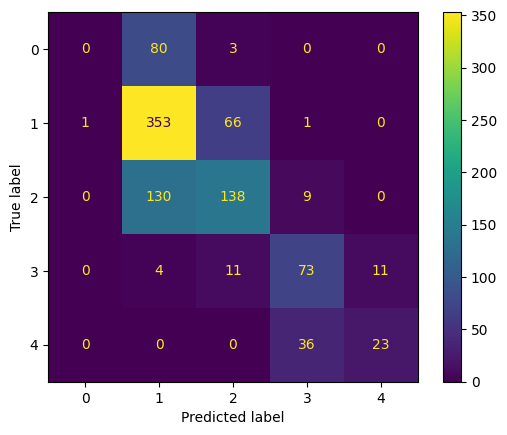

In [ ]:
cm = confusion_matrix(y_val, model.predict(X_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Попробуем обучить модель на признаках, значимость которых выше, чем 0.1

In [ ]:
need_features = fi_df[fi_df['f_importance'] > 0.1]['f_names'].tolist()

In [ ]:
df = pd.read_csv('./data/train_full.csv', index_col='Unnamed: 0')

need_features.append('target')
df = df[need_features]
df.shape

(6258, 31)

In [ ]:
df['target'] = minmax_scale(df['target'], feature_range=(1, 5), axis=0)
df['target'] = df['target'].apply(np.round).apply(int)

cat_features=[
    'atm_group', 'city',
    'city_district', 'federal_district',
    'administrative'
    ]

df[cat_features] = df[cat_features].fillna('no_data')
df['administrative'] = df['administrative'].apply(str)
df['atm_group'] = df['atm_group'].apply(str)
df = df.fillna(0)

df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['target'], axis=1)
y_train_val = df['target']
X_train, X_val, y_train, y_val = train_test_split(
    df_train_val, y_train_val,
    shuffle=True,
    stratify=y_train_val,
    train_size=0.85,
    random_state=DEFAULT_RANDOM_SEED
    )

train_pool = Pool(
    X_train, y_train,
    cat_features=[
        'atm_group', 'city',
        'city_district', 'federal_district',
        'administrative'
        ]
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=[
        'atm_group', 'city',
        'city_district', 'federal_district',
        'administrative'
        ]
)

print('Train dataset size: {}\n'.format(train_pool.shape))

Train dataset size: (5319, 30)



In [ ]:
model = fit_model(train_pool, validation_pool, 0.005)
f1_score(y_val, model.predict(X_val), average='micro')

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8375501	best: 0.8375501 (0)	total: 16.1ms	remaining: 8m 4s
100:	test: 0.8576735	best: 0.8577234 (97)	total: 1.25s	remaining: 6m 9s
200:	test: 0.8678477	best: 0.8678477 (200)	total: 2.29s	remaining: 5m 39s
300:	test: 0.8745307	best: 0.8745307 (300)	total: 3.31s	remaining: 5m 26s
400:	test: 0.8781086	best: 0.8781758 (399)	total: 4.84s	remaining: 5m 57s
500:	test: 0.8808420	best: 0.8808420 (500)	total: 9.41s	remaining: 9m 13s
600:	test: 0.8823258	best: 0.8824141 (596)	total: 14.1s	remaining: 11m 31s
700:	test: 0.8838986	best: 0.8840264 (692)	total: 15.7s	remaining: 10m 58s
800:	test: 0.8852516	best: 0.8852516 (800)	total: 17.1s	remaining: 10m 24s
900:	test: 0.8856933	best: 0.8858355 (879)	total: 18.5s	remaining: 9m 57s
1000:	test: 0.8860805	best: 0.8861285 (980)	total: 21.5s	remaining: 10m 22s
1100:	test: 0.8863698	best: 0.8864534 (1090)	total: 27.1s	remaining: 11m 51s
1200:	test: 0.8866216	best: 0.8866936 (1156)	total: 29.3s	remaining: 11m 42s
1300:	test: 0.8865896	best: 0.886

0.6187433439829606

Заметно, что качество модели упало.

Посмотрим на графики

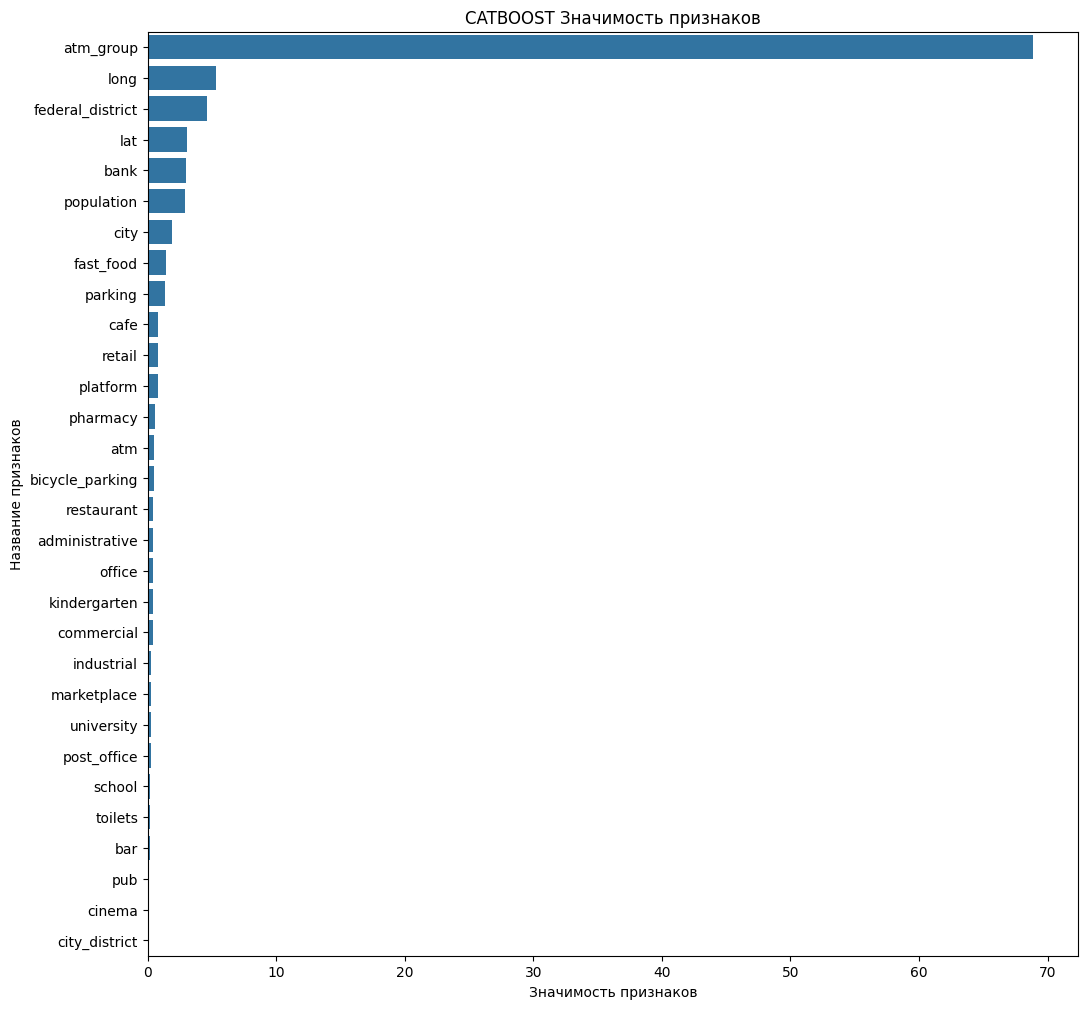

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'f_names':feature_names,'f_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['f_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(12,12))
    sns.barplot(x=fi_df['f_importance'], y=fi_df['f_names'])
    plt.title(model_type + 'Значимость признаков')
    plt.xlabel('Значимость признаков')
    plt.ylabel('Название признаков')

    return fi_df


fi_df = plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST ')

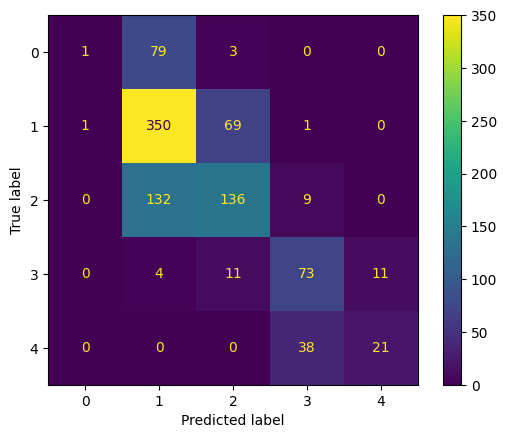

In [ ]:
cm = confusion_matrix(y_val, model.predict(X_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Моделирование DL

Загрузим и немного преобразуем заного данные

In [ ]:
df = pd.read_csv('./data/train_full.csv', index_col='Unnamed: 0')

df['target'] = minmax_scale(df['target'], feature_range=(0, 4), axis=0)
df['target'] = df['target'].apply(np.round).apply(int)

cat_features=[
    'atm_group', 'city',
    'city_district', 'federal_district',
    'administrative'
    ]

df[cat_features] = df[cat_features].fillna('no_data')
df['administrative'] = df['administrative'].apply(str)
df['atm_group'] = df['atm_group'].apply(str)
df = df.fillna(0)

df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['id', 'address', 'address_rus','target'], axis=1)
y_train_val = df['target']

df_train_val_num = df_train_val.select_dtypes('number')
df_train_val_cat = pd.get_dummies(df_train_val.select_dtypes('object'), dtype=int)

df_train_val = pd.concat([df_train_val_num, df_train_val_cat], axis=1, join='inner')

In [ ]:
X = torch.tensor(df_train_val.values, dtype=torch.float)
y = torch.tensor(y_train_val, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True, random_state=DEFAULT_RANDOM_SEED
    )

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4380, 1141]),
 torch.Size([1878, 1141]),
 torch.Size([4380]),
 torch.Size([1878]))

In [ ]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1141, 1141*4)
        self.act = nn.ReLU()
        self.output = nn.Linear(1141*4, 5)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

In [ ]:
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 256
# batches_per_epoch = len(X_train) // batch_size

In [ ]:
model

Multiclass(
  (hidden): Linear(in_features=1141, out_features=4564, bias=True)
  (act): ReLU()
  (output): Linear(in_features=4564, out_features=5, bias=True)
)

In [ ]:
best_acc = - np.inf
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [ ]:
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []

    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = ((torch.argmax(y_pred, 1) == y_batch).sum())/len(y_pred)
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = ((torch.argmax(y_pred, 1) == y_test).sum())/len(y_pred)
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0: 100%|██████████| 17/17 [00:06<00:00,  2.73batch/s, acc=0.414, loss=8.18]


Epoch 0 validation: Cross-entropy=6.76, Accuracy=37.4%


Epoch 1: 100%|██████████| 17/17 [00:04<00:00,  3.65batch/s, acc=0.473, loss=2.43]


Epoch 1 validation: Cross-entropy=2.66, Accuracy=45.6%


Epoch 2: 100%|██████████| 17/17 [00:02<00:00,  6.24batch/s, acc=0.461, loss=1.93]


Epoch 2 validation: Cross-entropy=1.87, Accuracy=45.6%


Epoch 3: 100%|██████████| 17/17 [00:03<00:00,  5.39batch/s, acc=0.48, loss=1.53]


Epoch 3 validation: Cross-entropy=1.67, Accuracy=33.7%


Epoch 4: 100%|██████████| 17/17 [00:03<00:00,  5.20batch/s, acc=0.5, loss=1.34]


Epoch 4 validation: Cross-entropy=1.41, Accuracy=41.8%


Epoch 5: 100%|██████████| 17/17 [00:02<00:00,  6.23batch/s, acc=0.5, loss=1.32]


Epoch 5 validation: Cross-entropy=1.40, Accuracy=40.6%


Epoch 6: 100%|██████████| 17/17 [00:02<00:00,  6.11batch/s, acc=0.488, loss=1.26]


Epoch 6 validation: Cross-entropy=1.57, Accuracy=39.0%


Epoch 7: 100%|██████████| 17/17 [00:03<00:00,  5.43batch/s, acc=0.512, loss=1.22]


Epoch 7 validation: Cross-entropy=1.41, Accuracy=41.6%


Epoch 8: 100%|██████████| 17/17 [00:03<00:00,  4.84batch/s, acc=0.508, loss=1.24]


Epoch 8 validation: Cross-entropy=1.44, Accuracy=40.2%


Epoch 9: 100%|██████████| 17/17 [00:02<00:00,  6.18batch/s, acc=0.555, loss=1.19]


Epoch 9 validation: Cross-entropy=1.37, Accuracy=42.9%


Epoch 10: 100%|██████████| 17/17 [00:02<00:00,  5.87batch/s, acc=0.504, loss=1.18]


Epoch 10 validation: Cross-entropy=1.38, Accuracy=43.9%


Epoch 11: 100%|██████████| 17/17 [00:02<00:00,  5.91batch/s, acc=0.531, loss=1.32]


Epoch 11 validation: Cross-entropy=1.40, Accuracy=42.8%


Epoch 12: 100%|██████████| 17/17 [00:03<00:00,  4.52batch/s, acc=0.52, loss=1.26]


Epoch 12 validation: Cross-entropy=1.33, Accuracy=47.1%


Epoch 13: 100%|██████████| 17/17 [00:02<00:00,  6.15batch/s, acc=0.508, loss=1.3]


Epoch 13 validation: Cross-entropy=1.27, Accuracy=48.8%


Epoch 14: 100%|██████████| 17/17 [00:02<00:00,  6.21batch/s, acc=0.57, loss=1.18]


Epoch 14 validation: Cross-entropy=1.30, Accuracy=47.9%


Epoch 15: 100%|██████████| 17/17 [00:02<00:00,  6.27batch/s, acc=0.523, loss=1.36]


Epoch 15 validation: Cross-entropy=1.45, Accuracy=47.8%


Epoch 16: 100%|██████████| 17/17 [00:03<00:00,  4.50batch/s, acc=0.539, loss=1.36]


Epoch 16 validation: Cross-entropy=1.43, Accuracy=46.0%


Epoch 17: 100%|██████████| 17/17 [00:02<00:00,  6.34batch/s, acc=0.598, loss=1.3]


Epoch 17 validation: Cross-entropy=1.42, Accuracy=49.7%


Epoch 18: 100%|██████████| 17/17 [00:02<00:00,  6.27batch/s, acc=0.516, loss=1.88]


Epoch 18 validation: Cross-entropy=1.46, Accuracy=50.9%


Epoch 19: 100%|██████████| 17/17 [00:02<00:00,  6.32batch/s, acc=0.469, loss=1.38]


Epoch 19 validation: Cross-entropy=1.91, Accuracy=39.3%


Epoch 20: 100%|██████████| 17/17 [00:03<00:00,  4.29batch/s, acc=0.566, loss=1.07]


Epoch 20 validation: Cross-entropy=1.52, Accuracy=41.6%


Epoch 21: 100%|██████████| 17/17 [00:02<00:00,  6.32batch/s, acc=0.52, loss=1.56]


Epoch 21 validation: Cross-entropy=2.05, Accuracy=41.5%


Epoch 22: 100%|██████████| 17/17 [00:02<00:00,  6.36batch/s, acc=0.621, loss=2.24]


Epoch 22 validation: Cross-entropy=1.80, Accuracy=52.3%


Epoch 23: 100%|██████████| 17/17 [00:02<00:00,  6.37batch/s, acc=0.379, loss=2.28]


Epoch 23 validation: Cross-entropy=2.04, Accuracy=43.9%


Epoch 24: 100%|██████████| 17/17 [00:03<00:00,  4.71batch/s, acc=0.527, loss=1.52]


Epoch 24 validation: Cross-entropy=1.94, Accuracy=40.1%


Epoch 25: 100%|██████████| 17/17 [00:02<00:00,  6.08batch/s, acc=0.426, loss=2.07]


Epoch 25 validation: Cross-entropy=2.70, Accuracy=39.8%


Epoch 26: 100%|██████████| 17/17 [00:02<00:00,  6.36batch/s, acc=0.496, loss=2.46]


Epoch 26 validation: Cross-entropy=2.17, Accuracy=42.0%


Epoch 27: 100%|██████████| 17/17 [00:02<00:00,  6.34batch/s, acc=0.578, loss=1.4]


Epoch 27 validation: Cross-entropy=1.67, Accuracy=46.1%


Epoch 28: 100%|██████████| 17/17 [00:03<00:00,  4.94batch/s, acc=0.574, loss=1.16]


Epoch 28 validation: Cross-entropy=1.14, Accuracy=54.0%


Epoch 29: 100%|██████████| 17/17 [00:03<00:00,  5.51batch/s, acc=0.605, loss=1.12]


Epoch 29 validation: Cross-entropy=1.20, Accuracy=53.9%


Epoch 30: 100%|██████████| 17/17 [00:02<00:00,  6.37batch/s, acc=0.66, loss=1.09]


Epoch 30 validation: Cross-entropy=1.17, Accuracy=55.2%


Epoch 31: 100%|██████████| 17/17 [00:02<00:00,  6.35batch/s, acc=0.633, loss=0.999]


Epoch 31 validation: Cross-entropy=1.39, Accuracy=39.5%


Epoch 32: 100%|██████████| 17/17 [00:03<00:00,  5.49batch/s, acc=0.633, loss=0.977]


Epoch 32 validation: Cross-entropy=1.28, Accuracy=48.6%


Epoch 33: 100%|██████████| 17/17 [00:03<00:00,  5.04batch/s, acc=0.66, loss=0.961]


Epoch 33 validation: Cross-entropy=1.25, Accuracy=50.2%


Epoch 34: 100%|██████████| 17/17 [00:02<00:00,  6.37batch/s, acc=0.676, loss=0.993]


Epoch 34 validation: Cross-entropy=1.23, Accuracy=53.1%


Epoch 35: 100%|██████████| 17/17 [00:02<00:00,  6.32batch/s, acc=0.688, loss=0.993]


Epoch 35 validation: Cross-entropy=1.35, Accuracy=43.9%


Epoch 36: 100%|██████████| 17/17 [00:02<00:00,  5.86batch/s, acc=0.621, loss=0.972]


Epoch 36 validation: Cross-entropy=1.27, Accuracy=51.8%


Epoch 37: 100%|██████████| 17/17 [00:03<00:00,  4.53batch/s, acc=0.586, loss=1.09]


Epoch 37 validation: Cross-entropy=1.19, Accuracy=49.3%


Epoch 38: 100%|██████████| 17/17 [00:02<00:00,  6.24batch/s, acc=0.652, loss=0.991]


Epoch 38 validation: Cross-entropy=1.14, Accuracy=54.7%


Epoch 39: 100%|██████████| 17/17 [00:02<00:00,  6.13batch/s, acc=0.602, loss=1.04]


Epoch 39 validation: Cross-entropy=1.11, Accuracy=57.0%


Epoch 40: 100%|██████████| 17/17 [00:02<00:00,  6.29batch/s, acc=0.637, loss=1]


Epoch 40 validation: Cross-entropy=1.17, Accuracy=53.6%


Epoch 41: 100%|██████████| 17/17 [00:04<00:00,  4.23batch/s, acc=0.66, loss=0.983]


Epoch 41 validation: Cross-entropy=1.20, Accuracy=48.5%


Epoch 42: 100%|██████████| 17/17 [00:02<00:00,  6.21batch/s, acc=0.656, loss=1.01]


Epoch 42 validation: Cross-entropy=1.33, Accuracy=44.5%


Epoch 43: 100%|██████████| 17/17 [00:02<00:00,  6.03batch/s, acc=0.59, loss=1]


Epoch 43 validation: Cross-entropy=1.17, Accuracy=57.6%


Epoch 44: 100%|██████████| 17/17 [00:02<00:00,  6.15batch/s, acc=0.703, loss=1.04]


Epoch 44 validation: Cross-entropy=1.14, Accuracy=52.6%


Epoch 45: 100%|██████████| 17/17 [00:04<00:00,  4.24batch/s, acc=0.645, loss=0.965]


Epoch 45 validation: Cross-entropy=1.37, Accuracy=46.5%


Epoch 46: 100%|██████████| 17/17 [00:02<00:00,  6.13batch/s, acc=0.613, loss=0.94]


Epoch 46 validation: Cross-entropy=1.10, Accuracy=56.7%


Epoch 47: 100%|██████████| 17/17 [00:02<00:00,  6.20batch/s, acc=0.66, loss=0.924]


Epoch 47 validation: Cross-entropy=1.19, Accuracy=51.4%


Epoch 48: 100%|██████████| 17/17 [00:02<00:00,  6.28batch/s, acc=0.68, loss=0.936]


Epoch 48 validation: Cross-entropy=1.17, Accuracy=53.7%


Epoch 49: 100%|██████████| 17/17 [00:03<00:00,  4.77batch/s, acc=0.645, loss=1.05]


Epoch 49 validation: Cross-entropy=1.15, Accuracy=49.4%


Epoch 50: 100%|██████████| 17/17 [00:02<00:00,  5.72batch/s, acc=0.637, loss=1.03]


Epoch 50 validation: Cross-entropy=1.20, Accuracy=49.1%


Epoch 51: 100%|██████████| 17/17 [00:02<00:00,  6.26batch/s, acc=0.684, loss=0.858]


Epoch 51 validation: Cross-entropy=1.17, Accuracy=51.6%


Epoch 52: 100%|██████████| 17/17 [00:02<00:00,  6.15batch/s, acc=0.707, loss=0.904]


Epoch 52 validation: Cross-entropy=1.17, Accuracy=53.6%


Epoch 53: 100%|██████████| 17/17 [00:03<00:00,  5.11batch/s, acc=0.625, loss=1.14]


Epoch 53 validation: Cross-entropy=1.10, Accuracy=54.1%


Epoch 54: 100%|██████████| 17/17 [00:03<00:00,  5.11batch/s, acc=0.691, loss=0.947]


Epoch 54 validation: Cross-entropy=1.19, Accuracy=52.0%


Epoch 55: 100%|██████████| 17/17 [00:02<00:00,  6.34batch/s, acc=0.664, loss=0.904]


Epoch 55 validation: Cross-entropy=1.21, Accuracy=50.9%


Epoch 56: 100%|██████████| 17/17 [00:02<00:00,  6.33batch/s, acc=0.645, loss=1.35]


Epoch 56 validation: Cross-entropy=1.28, Accuracy=56.5%


Epoch 57: 100%|██████████| 17/17 [00:03<00:00,  5.58batch/s, acc=0.625, loss=1.36]


Epoch 57 validation: Cross-entropy=1.51, Accuracy=53.7%


Epoch 58: 100%|██████████| 17/17 [00:03<00:00,  4.74batch/s, acc=0.645, loss=1.27]


Epoch 58 validation: Cross-entropy=1.37, Accuracy=48.7%


Epoch 59: 100%|██████████| 17/17 [00:02<00:00,  6.21batch/s, acc=0.613, loss=1.11]


Epoch 59 validation: Cross-entropy=1.59, Accuracy=44.7%


Epoch 60: 100%|██████████| 17/17 [00:02<00:00,  6.20batch/s, acc=0.672, loss=0.874]


Epoch 60 validation: Cross-entropy=1.28, Accuracy=49.8%


Epoch 61: 100%|██████████| 17/17 [00:02<00:00,  5.91batch/s, acc=0.672, loss=1.06]


Epoch 61 validation: Cross-entropy=1.47, Accuracy=43.7%


Epoch 62: 100%|██████████| 17/17 [00:03<00:00,  4.53batch/s, acc=0.645, loss=0.864]


Epoch 62 validation: Cross-entropy=1.05, Accuracy=57.4%


Epoch 63: 100%|██████████| 17/17 [00:02<00:00,  6.16batch/s, acc=0.711, loss=0.77]


Epoch 63 validation: Cross-entropy=1.22, Accuracy=51.2%


Epoch 64: 100%|██████████| 17/17 [00:02<00:00,  6.04batch/s, acc=0.68, loss=1.05]


Epoch 64 validation: Cross-entropy=1.20, Accuracy=53.8%


Epoch 65: 100%|██████████| 17/17 [00:04<00:00,  4.17batch/s, acc=0.707, loss=0.83]


Epoch 65 validation: Cross-entropy=1.19, Accuracy=51.3%


Epoch 66: 100%|██████████| 17/17 [00:03<00:00,  4.83batch/s, acc=0.699, loss=0.869]


Epoch 66 validation: Cross-entropy=1.18, Accuracy=50.3%


Epoch 67: 100%|██████████| 17/17 [00:02<00:00,  6.22batch/s, acc=0.684, loss=0.848]


Epoch 67 validation: Cross-entropy=1.20, Accuracy=51.1%


Epoch 68: 100%|██████████| 17/17 [00:02<00:00,  6.24batch/s, acc=0.672, loss=0.88]


Epoch 68 validation: Cross-entropy=1.22, Accuracy=53.8%


Epoch 69: 100%|██████████| 17/17 [00:02<00:00,  6.04batch/s, acc=0.742, loss=0.744]


Epoch 69 validation: Cross-entropy=1.38, Accuracy=43.3%


Epoch 70: 100%|██████████| 17/17 [00:03<00:00,  4.53batch/s, acc=0.73, loss=0.767]


Epoch 70 validation: Cross-entropy=1.23, Accuracy=49.5%


Epoch 71: 100%|██████████| 17/17 [00:02<00:00,  6.11batch/s, acc=0.699, loss=0.831]


Epoch 71 validation: Cross-entropy=1.12, Accuracy=55.0%


Epoch 72: 100%|██████████| 17/17 [00:02<00:00,  6.15batch/s, acc=0.711, loss=0.752]


Epoch 72 validation: Cross-entropy=1.40, Accuracy=42.7%


Epoch 73: 100%|██████████| 17/17 [00:02<00:00,  6.28batch/s, acc=0.723, loss=0.738]


Epoch 73 validation: Cross-entropy=1.36, Accuracy=42.8%


Epoch 74: 100%|██████████| 17/17 [00:03<00:00,  4.40batch/s, acc=0.754, loss=0.74]


Epoch 74 validation: Cross-entropy=1.25, Accuracy=49.3%


Epoch 75: 100%|██████████| 17/17 [00:02<00:00,  6.09batch/s, acc=0.715, loss=0.815]


Epoch 75 validation: Cross-entropy=1.21, Accuracy=51.3%


Epoch 76: 100%|██████████| 17/17 [00:02<00:00,  6.22batch/s, acc=0.766, loss=0.741]


Epoch 76 validation: Cross-entropy=1.28, Accuracy=49.0%


Epoch 77: 100%|██████████| 17/17 [00:02<00:00,  6.14batch/s, acc=0.73, loss=0.753]


Epoch 77 validation: Cross-entropy=1.36, Accuracy=42.1%


Epoch 78: 100%|██████████| 17/17 [00:03<00:00,  4.36batch/s, acc=0.695, loss=0.837]


Epoch 78 validation: Cross-entropy=1.24, Accuracy=50.5%


Epoch 79: 100%|██████████| 17/17 [00:02<00:00,  6.18batch/s, acc=0.691, loss=0.867]


Epoch 79 validation: Cross-entropy=1.05, Accuracy=58.7%


Epoch 80: 100%|██████████| 17/17 [00:02<00:00,  6.09batch/s, acc=0.652, loss=0.819]


Epoch 80 validation: Cross-entropy=1.24, Accuracy=52.1%


Epoch 81: 100%|██████████| 17/17 [00:02<00:00,  6.17batch/s, acc=0.68, loss=0.869]


Epoch 81 validation: Cross-entropy=1.45, Accuracy=41.4%


Epoch 82: 100%|██████████| 17/17 [00:04<00:00,  4.20batch/s, acc=0.656, loss=0.918]


Epoch 82 validation: Cross-entropy=1.21, Accuracy=51.5%


Epoch 83: 100%|██████████| 17/17 [00:02<00:00,  6.16batch/s, acc=0.676, loss=0.94]


Epoch 83 validation: Cross-entropy=1.34, Accuracy=43.0%


Epoch 84: 100%|██████████| 17/17 [00:02<00:00,  6.11batch/s, acc=0.695, loss=0.788]


Epoch 84 validation: Cross-entropy=1.06, Accuracy=56.0%


Epoch 85: 100%|██████████| 17/17 [00:02<00:00,  6.21batch/s, acc=0.703, loss=0.771]


Epoch 85 validation: Cross-entropy=1.12, Accuracy=54.4%


Epoch 86: 100%|██████████| 17/17 [00:03<00:00,  4.49batch/s, acc=0.715, loss=0.687]


Epoch 86 validation: Cross-entropy=1.29, Accuracy=45.5%


Epoch 87: 100%|██████████| 17/17 [00:02<00:00,  5.99batch/s, acc=0.754, loss=0.688]


Epoch 87 validation: Cross-entropy=1.20, Accuracy=51.5%


Epoch 88: 100%|██████████| 17/17 [00:02<00:00,  6.24batch/s, acc=0.758, loss=0.716]


Epoch 88 validation: Cross-entropy=1.23, Accuracy=49.4%


Epoch 89: 100%|██████████| 17/17 [00:02<00:00,  6.02batch/s, acc=0.758, loss=0.682]


Epoch 89 validation: Cross-entropy=1.24, Accuracy=48.9%


Epoch 90: 100%|██████████| 17/17 [00:03<00:00,  4.61batch/s, acc=0.715, loss=0.734]


Epoch 90 validation: Cross-entropy=1.21, Accuracy=52.1%


Epoch 91: 100%|██████████| 17/17 [00:02<00:00,  5.77batch/s, acc=0.738, loss=0.704]


Epoch 91 validation: Cross-entropy=1.19, Accuracy=52.7%


Epoch 92: 100%|██████████| 17/17 [00:02<00:00,  6.28batch/s, acc=0.75, loss=0.721]


Epoch 92 validation: Cross-entropy=1.33, Accuracy=44.1%


Epoch 93: 100%|██████████| 17/17 [00:02<00:00,  6.25batch/s, acc=0.75, loss=0.693]


Epoch 93 validation: Cross-entropy=1.22, Accuracy=51.0%


Epoch 94: 100%|██████████| 17/17 [00:03<00:00,  4.89batch/s, acc=0.762, loss=0.694]


Epoch 94 validation: Cross-entropy=1.26, Accuracy=49.6%


Epoch 95: 100%|██████████| 17/17 [00:03<00:00,  5.37batch/s, acc=0.738, loss=0.689]


Epoch 95 validation: Cross-entropy=1.22, Accuracy=52.2%


Epoch 96: 100%|██████████| 17/17 [00:02<00:00,  6.20batch/s, acc=0.777, loss=0.681]


Epoch 96 validation: Cross-entropy=1.30, Accuracy=46.9%


Epoch 97: 100%|██████████| 17/17 [00:02<00:00,  6.18batch/s, acc=0.75, loss=0.681]


Epoch 97 validation: Cross-entropy=1.25, Accuracy=49.9%


Epoch 98: 100%|██████████| 17/17 [00:03<00:00,  5.06batch/s, acc=0.754, loss=0.687]


Epoch 98 validation: Cross-entropy=1.31, Accuracy=46.1%


Epoch 99: 100%|██████████| 17/17 [00:03<00:00,  5.07batch/s, acc=0.746, loss=0.681]


Epoch 99 validation: Cross-entropy=1.22, Accuracy=52.0%


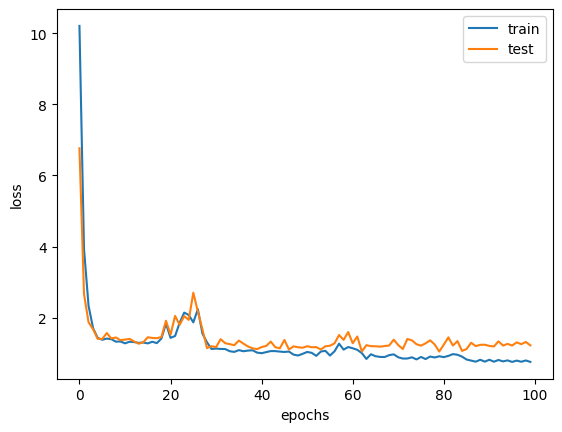

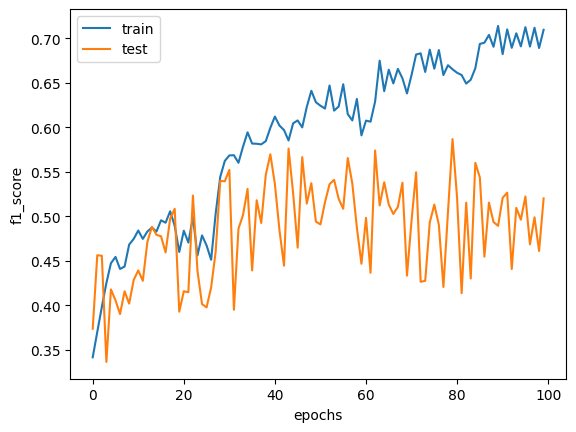

In [ ]:
# Restore best model
model.load_state_dict(best_weights)

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.legend()
plt.show()

Повторим эксперимент, но уже с нормализованными числовыми признаками.

In [ ]:
df = pd.read_csv('./data/train_full.csv', index_col='Unnamed: 0')

df['target'] = minmax_scale(df['target'], feature_range=(0, 4), axis=0)
df['target'] = df['target'].apply(np.round).apply(int)

cat_features=[
    'atm_group', 'city',
    'city_district', 'federal_district',
    'administrative'
    ]

df[cat_features] = df[cat_features].fillna('no_data')
df['administrative'] = df['administrative'].apply(str)
df['atm_group'] = df['atm_group'].apply(str)
df = df.fillna(0)

df.reset_index(drop=True, inplace=True)

df_train_val = df.drop(['id', 'address', 'address_rus','target'], axis=1)
y_train_val = df['target']

df_train_val_num = df_train_val.select_dtypes('number')
df_train_val_cat = pd.get_dummies(df_train_val.select_dtypes('object'), dtype=int)

x = df_train_val_num.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train_val_num_scaled = pd.DataFrame(x_scaled, columns=df_train_val_num.columns)
df_train_val_num_scaled

df_train_val = pd.concat([df_train_val_num_scaled, df_train_val_cat], axis=1, join='inner')

In [ ]:
X = torch.tensor(df_train_val.values, dtype=torch.float)
y = torch.tensor(y_train_val, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True, random_state=DEFAULT_RANDOM_SEED
    )

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4380, 1141]),
 torch.Size([1878, 1141]),
 torch.Size([4380]),
 torch.Size([1878]))

In [ ]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1141, 1141*4)
        self.act = nn.ReLU()
        self.output = nn.Linear(1141*4, 5)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

In [ ]:
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 50
batch_size = 256
batches_per_epoch = len(X_train) // batch_size

In [ ]:
best_acc = - np.inf
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [ ]:
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []

    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = ((torch.argmax(y_pred, 1) == y_batch).sum())/len(y_pred)
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = ((torch.argmax(y_pred, 1) == y_test).sum())/len(y_pred)
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0: 100%|██████████| 17/17 [00:04<00:00,  3.56batch/s, acc=0.496, loss=1.46]


Epoch 0 validation: Cross-entropy=1.46, Accuracy=47.7%


Epoch 1: 100%|██████████| 17/17 [00:03<00:00,  5.18batch/s, acc=0.492, loss=1.33]


Epoch 1 validation: Cross-entropy=1.35, Accuracy=47.1%


Epoch 2: 100%|██████████| 17/17 [00:03<00:00,  4.98batch/s, acc=0.496, loss=1.24]


Epoch 2 validation: Cross-entropy=1.28, Accuracy=47.7%


Epoch 3: 100%|██████████| 17/17 [00:02<00:00,  6.24batch/s, acc=0.504, loss=1.18]


Epoch 3 validation: Cross-entropy=1.23, Accuracy=48.0%


Epoch 4: 100%|██████████| 17/17 [00:02<00:00,  5.91batch/s, acc=0.5, loss=1.13]


Epoch 4 validation: Cross-entropy=1.19, Accuracy=48.8%


Epoch 5: 100%|██████████| 17/17 [00:03<00:00,  5.26batch/s, acc=0.523, loss=1.08]


Epoch 5 validation: Cross-entropy=1.14, Accuracy=50.1%


Epoch 6: 100%|██████████| 17/17 [00:03<00:00,  4.73batch/s, acc=0.578, loss=1.02]


Epoch 6 validation: Cross-entropy=1.10, Accuracy=52.9%


Epoch 7: 100%|██████████| 17/17 [00:02<00:00,  6.36batch/s, acc=0.625, loss=0.967]


Epoch 7 validation: Cross-entropy=1.05, Accuracy=57.1%


Epoch 8: 100%|██████████| 17/17 [00:02<00:00,  6.41batch/s, acc=0.664, loss=0.918]


Epoch 8 validation: Cross-entropy=1.02, Accuracy=58.9%


Epoch 9: 100%|██████████| 17/17 [00:02<00:00,  6.37batch/s, acc=0.664, loss=0.877]


Epoch 9 validation: Cross-entropy=0.99, Accuracy=59.5%


Epoch 10: 100%|██████████| 17/17 [00:03<00:00,  4.51batch/s, acc=0.668, loss=0.844]


Epoch 10 validation: Cross-entropy=0.97, Accuracy=60.1%


Epoch 11: 100%|██████████| 17/17 [00:02<00:00,  6.37batch/s, acc=0.668, loss=0.817]


Epoch 11 validation: Cross-entropy=0.95, Accuracy=60.1%


Epoch 12: 100%|██████████| 17/17 [00:02<00:00,  6.48batch/s, acc=0.664, loss=0.795]


Epoch 12 validation: Cross-entropy=0.94, Accuracy=59.9%


Epoch 13: 100%|██████████| 17/17 [00:02<00:00,  6.48batch/s, acc=0.664, loss=0.776]


Epoch 13 validation: Cross-entropy=0.93, Accuracy=60.6%


Epoch 14: 100%|██████████| 17/17 [00:03<00:00,  4.74batch/s, acc=0.672, loss=0.761]


Epoch 14 validation: Cross-entropy=0.92, Accuracy=60.5%


Epoch 15: 100%|██████████| 17/17 [00:02<00:00,  6.09batch/s, acc=0.668, loss=0.747]


Epoch 15 validation: Cross-entropy=0.92, Accuracy=60.5%


Epoch 16: 100%|██████████| 17/17 [00:02<00:00,  6.50batch/s, acc=0.668, loss=0.735]


Epoch 16 validation: Cross-entropy=0.92, Accuracy=60.8%


Epoch 17: 100%|██████████| 17/17 [00:02<00:00,  6.57batch/s, acc=0.676, loss=0.724]


Epoch 17 validation: Cross-entropy=0.91, Accuracy=60.3%


Epoch 18: 100%|██████████| 17/17 [00:03<00:00,  5.47batch/s, acc=0.688, loss=0.713]


Epoch 18 validation: Cross-entropy=0.91, Accuracy=60.2%


Epoch 19: 100%|██████████| 17/17 [00:03<00:00,  5.30batch/s, acc=0.691, loss=0.704]


Epoch 19 validation: Cross-entropy=0.91, Accuracy=60.2%


Epoch 20: 100%|██████████| 17/17 [00:02<00:00,  6.49batch/s, acc=0.688, loss=0.695]


Epoch 20 validation: Cross-entropy=0.91, Accuracy=60.1%


Epoch 21: 100%|██████████| 17/17 [00:02<00:00,  6.51batch/s, acc=0.695, loss=0.686]


Epoch 21 validation: Cross-entropy=0.91, Accuracy=60.0%


Epoch 22: 100%|██████████| 17/17 [00:02<00:00,  6.36batch/s, acc=0.711, loss=0.678]


Epoch 22 validation: Cross-entropy=0.91, Accuracy=60.3%


Epoch 23: 100%|██████████| 17/17 [00:03<00:00,  4.63batch/s, acc=0.711, loss=0.671]


Epoch 23 validation: Cross-entropy=0.91, Accuracy=60.3%


Epoch 24: 100%|██████████| 17/17 [00:02<00:00,  6.33batch/s, acc=0.715, loss=0.663]


Epoch 24 validation: Cross-entropy=0.91, Accuracy=60.6%


Epoch 25: 100%|██████████| 17/17 [00:02<00:00,  6.54batch/s, acc=0.734, loss=0.656]


Epoch 25 validation: Cross-entropy=0.91, Accuracy=60.6%


Epoch 26: 100%|██████████| 17/17 [00:02<00:00,  6.53batch/s, acc=0.734, loss=0.65]


Epoch 26 validation: Cross-entropy=0.92, Accuracy=60.6%


Epoch 27: 100%|██████████| 17/17 [00:03<00:00,  4.84batch/s, acc=0.734, loss=0.643]


Epoch 27 validation: Cross-entropy=0.92, Accuracy=60.6%


Epoch 28: 100%|██████████| 17/17 [00:02<00:00,  6.07batch/s, acc=0.734, loss=0.637]


Epoch 28 validation: Cross-entropy=0.92, Accuracy=60.6%


Epoch 29: 100%|██████████| 17/17 [00:02<00:00,  6.59batch/s, acc=0.734, loss=0.631]


Epoch 29 validation: Cross-entropy=0.92, Accuracy=60.5%


Epoch 30: 100%|██████████| 17/17 [00:02<00:00,  6.57batch/s, acc=0.738, loss=0.625]


Epoch 30 validation: Cross-entropy=0.92, Accuracy=60.5%


Epoch 31: 100%|██████████| 17/17 [00:02<00:00,  5.74batch/s, acc=0.734, loss=0.619]


Epoch 31 validation: Cross-entropy=0.93, Accuracy=60.3%


Epoch 32: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, acc=0.734, loss=0.614]


Epoch 32 validation: Cross-entropy=0.93, Accuracy=60.2%


Epoch 33: 100%|██████████| 17/17 [00:02<00:00,  6.42batch/s, acc=0.734, loss=0.609]


Epoch 33 validation: Cross-entropy=0.93, Accuracy=60.1%


Epoch 34: 100%|██████████| 17/17 [00:02<00:00,  6.47batch/s, acc=0.734, loss=0.604]


Epoch 34 validation: Cross-entropy=0.93, Accuracy=60.3%


Epoch 35: 100%|██████████| 17/17 [00:02<00:00,  5.92batch/s, acc=0.734, loss=0.599]


Epoch 35 validation: Cross-entropy=0.94, Accuracy=60.1%


Epoch 36: 100%|██████████| 17/17 [00:03<00:00,  4.92batch/s, acc=0.734, loss=0.595]


Epoch 36 validation: Cross-entropy=0.94, Accuracy=60.2%


Epoch 37: 100%|██████████| 17/17 [00:02<00:00,  6.54batch/s, acc=0.738, loss=0.59]


Epoch 37 validation: Cross-entropy=0.94, Accuracy=60.3%


Epoch 38: 100%|██████████| 17/17 [00:02<00:00,  6.50batch/s, acc=0.738, loss=0.586]


Epoch 38 validation: Cross-entropy=0.94, Accuracy=60.4%


Epoch 39: 100%|██████████| 17/17 [00:02<00:00,  6.48batch/s, acc=0.742, loss=0.582]


Epoch 39 validation: Cross-entropy=0.95, Accuracy=60.3%


Epoch 40: 100%|██████████| 17/17 [00:03<00:00,  4.45batch/s, acc=0.754, loss=0.577]


Epoch 40 validation: Cross-entropy=0.95, Accuracy=60.4%


Epoch 41: 100%|██████████| 17/17 [00:02<00:00,  6.46batch/s, acc=0.758, loss=0.574]


Epoch 41 validation: Cross-entropy=0.95, Accuracy=60.3%


Epoch 42: 100%|██████████| 17/17 [00:02<00:00,  6.25batch/s, acc=0.758, loss=0.57]


Epoch 42 validation: Cross-entropy=0.95, Accuracy=60.2%


Epoch 43: 100%|██████████| 17/17 [00:02<00:00,  6.44batch/s, acc=0.766, loss=0.566]


Epoch 43 validation: Cross-entropy=0.96, Accuracy=60.1%


Epoch 44: 100%|██████████| 17/17 [00:03<00:00,  4.95batch/s, acc=0.766, loss=0.562]


Epoch 44 validation: Cross-entropy=0.96, Accuracy=60.0%


Epoch 45: 100%|██████████| 17/17 [00:02<00:00,  5.78batch/s, acc=0.766, loss=0.559]


Epoch 45 validation: Cross-entropy=0.96, Accuracy=59.9%


Epoch 46: 100%|██████████| 17/17 [00:02<00:00,  6.38batch/s, acc=0.766, loss=0.555]


Epoch 46 validation: Cross-entropy=0.97, Accuracy=59.9%


Epoch 47: 100%|██████████| 17/17 [00:02<00:00,  6.38batch/s, acc=0.77, loss=0.552]


Epoch 47 validation: Cross-entropy=0.97, Accuracy=59.7%


Epoch 48: 100%|██████████| 17/17 [00:03<00:00,  5.43batch/s, acc=0.77, loss=0.549]


Epoch 48 validation: Cross-entropy=0.97, Accuracy=59.8%


Epoch 49: 100%|██████████| 17/17 [00:03<00:00,  5.17batch/s, acc=0.77, loss=0.546]


Epoch 49 validation: Cross-entropy=0.98, Accuracy=59.5%


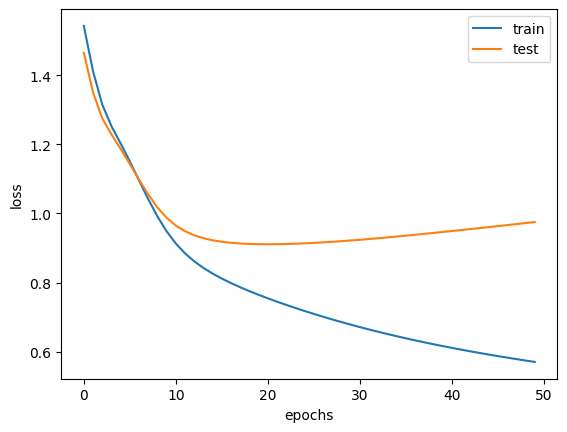

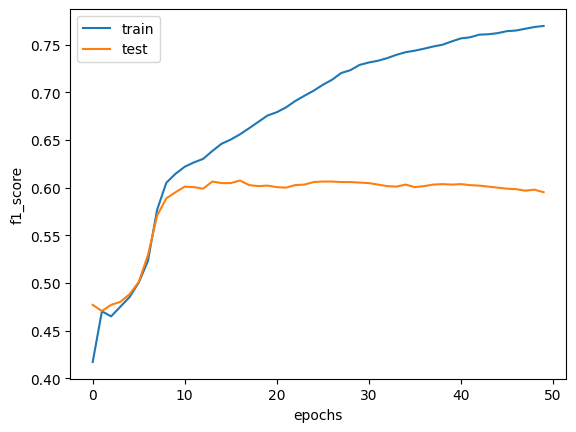

In [ ]:
# Restore best model
model.load_state_dict(best_weights)

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.legend()
plt.show()